# Obtain test predictions for predictor

In [1]:
%load_ext autoreload
%autoreload 2

In [86]:
# from pts.model.simple_feedforward import SimpleFeedForwardTrainingNetwork
# from pts.model.simple_feedforward import SimpleFeedForwardEstimator
from models.simple_feedforward_estimator import SimpleFeedForwardEstimator
from models.simple_feedforward_network import SimpleFeedForwardTrainingNetwork
from pts import Trainer
import torch
import pprint
import pickle
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt 

from pathlib import Path

from gluonts.mx import DistributionOutput, GaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.torch.model.predictor import PyTorchPredictor

from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator


from pts.modules import NormalOutput

from training_utils import get_scaled_datasets, dataset_metadata, get_rolled_dataset

In [3]:

device = torch.device("cpu")

# estimator = SimpleFeedForwardEstimator(
#     prediction_length=1,
#     context_length=5,
#     freq=dataset_metadata['freq'],
#     num_hidden_dimensions=[162, 40, 40, 1], # dims[0] = 27 * (past_features + future_features)
#     # distr_output=NormalOutput(),
#     trainer=Trainer(
#         device=device,
#         epochs=7,
#         learning_rate=1e-3,
#         num_batches_per_epoch=20000
#     )
# )

from models.tempflow_estimator import TempFlowEstimator

tempflow_estimator = TempFlowEstimator(
    target_dim=1,
    prediction_length=1,
    cell_type='GRU',
    context_length=3,
    input_size=27,
    freq=dataset_metadata['freq'],
    scaling=False,
    dequantize=False,
    n_blocks=3,
    trainer=Trainer(device=device,
                    epochs=3,
                    learning_rate=1e-3,
                    num_batches_per_epoch=20000,
                    batch_size=32)
)


In [4]:
train_ds, test_ds = get_scaled_datasets()

(926340, 27) (926340, 1)
len(train_days), len(test_days) 14 6


In [5]:
predictor = PyTorchPredictor.deserialize(Path('./checkpoints/simple_feedforward'))

In [6]:
with open('./checkpoints/tempflow_predictor_trained.pkl', 'rb') as f:
    tempflow_predictor_trained = pickle.load(f)
    
tempflow_predictor = tempflow_estimator.create_predictor(tempflow_predictor_trained.transformation, tempflow_predictor_trained.trained_net, device)

In [7]:
test_ds_rolled = get_rolled_dataset(test_ds, 
                                     context_length=5,
                                     prediction_length=1, max_size=1000)

6it [00:00, 216.94it/s]


In [8]:
len(test_ds_rolled)

1000

In [9]:
forecast_it, ts_it = make_evaluation_predictions(
    test_ds_rolled, predictor=predictor, num_samples=10
)

In [161]:
agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=1000
)


Running evaluation: 100%|██████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.38it/s]/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:150: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error

/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:150: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error
/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in double_scala

In [162]:
pprint.pprint(agg_metrics)

{'Coverage[0.1]': 0.433,
 'Coverage[0.2]': 0.476,
 'Coverage[0.3]': 0.508,
 'Coverage[0.4]': 0.538,
 'Coverage[0.5]': 0.538,
 'Coverage[0.6]': 0.573,
 'Coverage[0.7]': 0.6,
 'Coverage[0.8]': 0.63,
 'Coverage[0.9]': 0.663,
 'MAE_Coverage': 0.1696666666666667,
 'MAPE': 1.298449830021709,
 'MASE': inf,
 'MSE': 8.299214181276183,
 'MSIS': inf,
 'ND': 1.0010609309288423,
 'NRMSE': 1.2333307754310996,
 'OWA': nan,
 'QuantileLoss[0.1]': 1936.1223702654243,
 'QuantileLoss[0.2]': 2211.1964823350313,
 'QuantileLoss[0.3]': 2339.5961681351064,
 'QuantileLoss[0.4]': 2378.06243237108,
 'QuantileLoss[0.5]': 2338.295694258064,
 'QuantileLoss[0.6]': 2279.649667674303,
 'QuantileLoss[0.7]': 2151.2097273387017,
 'QuantileLoss[0.8]': 1960.0315918467936,
 'QuantileLoss[0.9]': 1637.9680867105722,
 'RMSE': 2.8808356741189147,
 'abs_error': 2338.295694258064,
 'abs_target_mean': 2.3358175531717715,
 'abs_target_sum': 2335.8175531717716,
 'mean_absolute_QuantileLoss': 2136.903580103897,
 'mean_wQuantileLoss': 

In [44]:
pprint.pprint(agg_metrics)

{'Coverage[0.1]': 0.426,
 'Coverage[0.2]': 0.47,
 'Coverage[0.3]': 0.514,
 'Coverage[0.4]': 0.545,
 'Coverage[0.5]': 0.545,
 'Coverage[0.6]': 0.571,
 'Coverage[0.7]': 0.594,
 'Coverage[0.8]': 0.625,
 'Coverage[0.9]': 0.668,
 'MAE_Coverage': 0.17133333333333334,
 'MAPE': 1.4602969701243564,
 'MASE': inf,
 'MSE': 8.329459075400242,
 'MSIS': inf,
 'ND': 1.0026766198315942,
 'NRMSE': 1.2355760503894058,
 'OWA': nan,
 'QuantileLoss[0.1]': 1940.7388578563928,
 'QuantileLoss[0.2]': 2212.9440883353354,
 'QuantileLoss[0.3]': 2334.8221301335843,
 'QuantileLoss[0.4]': 2381.051721011102,
 'QuantileLoss[0.5]': 2342.069648757577,
 'QuantileLoss[0.6]': 2294.389885224402,
 'QuantileLoss[0.7]': 2170.838180592656,
 'QuantileLoss[0.8]': 1973.2957521468402,
 'QuantileLoss[0.9]': 1646.2354305192828,
 'RMSE': 2.8860802267782235,
 'abs_error': 2342.069648757577,
 'abs_target_mean': 2.3358175531717715,
 'abs_target_sum': 2335.8175531717716,
 'mean_absolute_QuantileLoss': 2144.0428549530193,
 'mean_wQuantileLo

# Normalizing flow metrics

In [17]:
tempflow_forecast_it, tempflow_ts_it = make_evaluation_predictions(
    test_ds_rolled, predictor=tempflow_predictor, num_samples=10
)

In [19]:
tempflow_agg_metrics, tempflow_item_metrics = Evaluator()(
    tempflow_ts_it, tempflow_forecast_it, num_series=1000
)


Running evaluation: 100%|██████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.14it/s]/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:150: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error

/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:150: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error
/usr/twix/python/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in double_scala

In [147]:
pprint.pprint(tempflow_agg_metrics)

{'Coverage[0.1]': 0.442,
 'Coverage[0.2]': 0.478,
 'Coverage[0.3]': 0.514,
 'Coverage[0.4]': 0.562,
 'Coverage[0.5]': 0.562,
 'Coverage[0.6]': 0.594,
 'Coverage[0.7]': 0.621,
 'Coverage[0.8]': 0.651,
 'Coverage[0.9]': 0.682,
 'MAE_Coverage': 0.16777777777777778,
 'MAPE': 1.6693398574091842,
 'MASE': inf,
 'MSE': 8.442871039492253,
 'MSIS': inf,
 'ND': 1.0100890570385455,
 'NRMSE': 1.2439592679578027,
 'OWA': nan,
 'QuantileLoss[0.1]': 1887.3000466808676,
 'QuantileLoss[0.2]': 2187.9591133620124,
 'QuantileLoss[0.3]': 2339.8101180307567,
 'QuantileLoss[0.4]': 2405.405318406224,
 'QuantileLoss[0.5]': 2359.3837496973574,
 'QuantileLoss[0.6]': 2307.6551102265717,
 'QuantileLoss[0.7]': 2174.1531159780925,
 'QuantileLoss[0.8]': 1946.3681084632872,
 'QuantileLoss[0.9]': 1596.9502524480222,
 'RMSE': 2.905661893526543,
 'abs_error': 2359.3837496973574,
 'abs_target_mean': 2.3358175531717715,
 'abs_target_sum': 2335.8175531717716,
 'mean_absolute_QuantileLoss': 2133.8872148103546,
 'mean_wQuanti

In [21]:
pprint.pprint(tempflow_agg_metrics)

{'Coverage[0.1]': 0.428,
 'Coverage[0.2]': 0.475,
 'Coverage[0.3]': 0.514,
 'Coverage[0.4]': 0.556,
 'Coverage[0.5]': 0.556,
 'Coverage[0.6]': 0.596,
 'Coverage[0.7]': 0.621,
 'Coverage[0.8]': 0.649,
 'Coverage[0.9]': 0.681,
 'MAE_Coverage': 0.16466666666666668,
 'MAPE': 1.6947497101780027,
 'MASE': inf,
 'MSE': 8.419740905687558,
 'MSIS': inf,
 'ND': 1.017976965450974,
 'NRMSE': 1.2422541206300404,
 'OWA': nan,
 'QuantileLoss[0.1]': 1881.8996403887868,
 'QuantileLoss[0.2]': 2170.8257398560645,
 'QuantileLoss[0.3]': 2338.0830448780207,
 'QuantileLoss[0.4]': 2424.18204770796,
 'QuantileLoss[0.5]': 2377.808464624919,
 'QuantileLoss[0.6]': 2318.416647338867,
 'QuantileLoss[0.7]': 2183.807284957171,
 'QuantileLoss[0.8]': 1934.4026656240226,
 'QuantileLoss[0.9]': 1579.272517696023,
 'RMSE': 2.9016789804676115,
 'abs_error': 2377.808464624919,
 'abs_target_mean': 2.3358175531717715,
 'abs_target_sum': 2335.8175531717716,
 'mean_absolute_QuantileLoss': 2134.2997836746486,
 'mean_wQuantileLoss

# Write profit metric

In [82]:
def get_targets_and_preds(forecast_it, ts_it):
    targets = []
    pred_distributions = []
    for pred_distribution, target in tqdm(zip(forecast_it, ts_it)):
        target = target.values[0][0]
        targets.append(target)
        pred_distributions.append(pred_distribution.samples)

    targets = np.array(targets)
    pred_distributions = np.array(pred_distributions).squeeze()
    return targets, pred_distributions

In [87]:
forecast_it, ts_it = make_evaluation_predictions(
    test_ds_rolled, predictor=predictor, num_samples=10
)

targets, pred_distributions = get_targets_and_preds(forecast_it, ts_it)

1000it [00:00, 1467.47it/s]


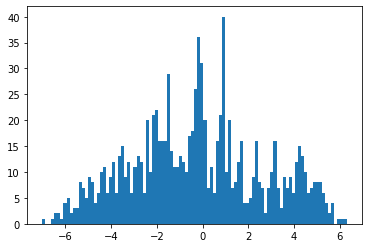

In [88]:
plt.hist(targets, bins=100);

In [89]:
pred_distributions.shape

(1000, 10)

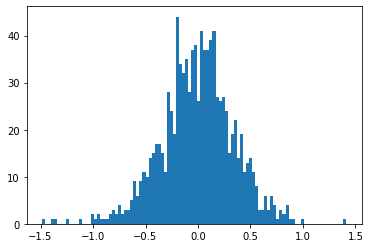

In [90]:
plt.hist(pred_distributions.mean(1), bins=100);

In [28]:
def max_profit_metric(predictions, targets):
    permutation = predictions.argsort()[::-1]
    profit_cumsum = np.cumsum(targets[permutation])
    best_threshold_index = np.argmax(profit_cumsum)
    max_profit = profit_cumsum[best_threshold_index]    
    return max_profit, best_threshold_index / len(profit_cumsum)

In [123]:
max_profit_metric(pred_distributions.mean(1), targets)

(11.350938, 0.024)

In [111]:
mean_max_profit, ratio = max_profit_metric(pred_distributions.mean(1), targets)
mean_max_profit, ratio

(21.943178, 0.11)

In [98]:
pred_quantiles = np.quantile(pred_distributions, [0.3, 0.5, 0.8], axis=-1)

In [102]:
quantiles_range = np.linspace(0.01, 0.99, num=50)

In [103]:
pred_quantiles_range = np.quantile(pred_distributions, quantiles_range, axis=-1)

In [99]:
max_profit_metric(pred_quantiles[1], targets)

(25.805428, 0.017)

In [107]:
profits = []
ratios = []
for q in pred_quantiles_range:
    profit, ratio = max_profit_metric(q, targets)
    profits.append(profit)
    ratios.append(ratio)

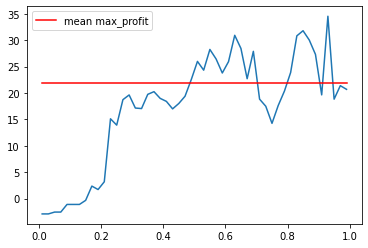

In [114]:
plt.plot(quantiles_range, profits)
plt.plot(quantiles_range, np.ones_like(profits) * mean_max_profit, color='red', label='mean max_profit')
plt.legend()

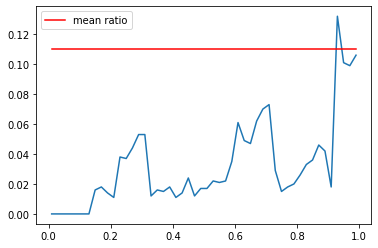

In [115]:
plt.plot(quantiles_range, ratios)
plt.plot(quantiles_range, np.ones_like(profits) * ratio, color='red', label='mean ratio')
plt.legend()

# Max-profit normalizing flow

In [116]:
tempflow_forecast_it, tempflow_ts_it = make_evaluation_predictions(
    test_ds_rolled, predictor=tempflow_predictor, num_samples=10
)
targets, pred_distributions = get_targets_and_preds(tempflow_forecast_it, tempflow_ts_it)

1000it [00:10, 98.81it/s]


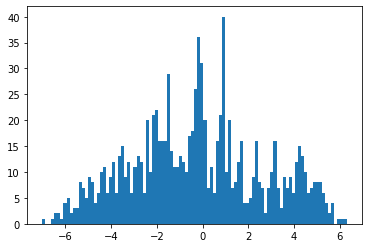

In [117]:
plt.hist(targets, bins=100);

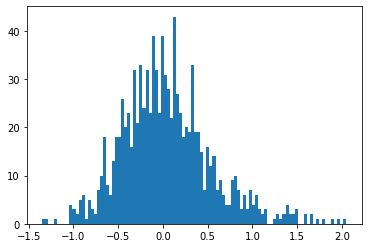

In [118]:
plt.hist(pred_distributions.mean(1), bins=100);

In [40]:
max_profit_metric(pred_distributions.mean(1), targets)

(1.0939889, 0.194)

In [127]:
mean_max_profit, mean_ratio = max_profit_metric(pred_distributions.mean(1), targets)
mean_max_profit, mean_ratio

(2.9412181, 0.003)

In [120]:
pred_quantiles_range = np.quantile(pred_distributions, quantiles_range, axis=-1)

In [122]:
profits = []
ratios = []
for q in pred_quantiles_range:
    profit, ratio = max_profit_metric(q, targets)
    profits.append(profit)
    ratios.append(ratio)

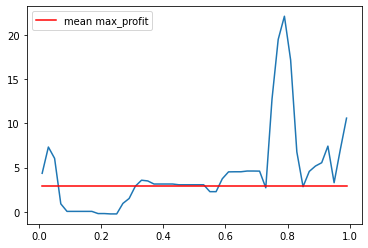

In [131]:
plt.plot(quantiles_range, profits)
plt.plot(quantiles_range, np.ones_like(profits) * mean_max_profit, color='red', label='mean max_profit')
plt.legend()

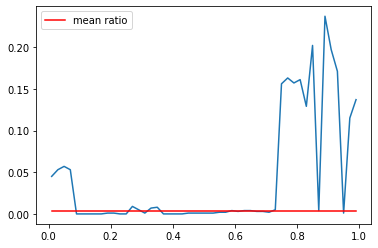

In [132]:
plt.plot(quantiles_range, ratios)
plt.plot(quantiles_range, np.ones_like(profits) * mean_ratio, color='red', label='mean ratio')
plt.legend()

In [130]:
targets.sum()

-239.87888

# Random predictions

In [174]:
random_predictions = np.random.rand(*pred_distributions.shape)

In [175]:
def get_pred_max_profit_for_quantiles(predictions):
    quantiles_range = np.linspace(0.01, 0.99, num=50)
    pred_quantiles_range = np.quantile(predictions, quantiles_range, axis=-1)
    profits = []
    ratios = []
    for q in pred_quantiles_range:
        profit, ratio = max_profit_metric(q, targets)
        profits.append(profit)
        ratios.append(ratio)
        
    return profits, ratios

8.409109 0.003


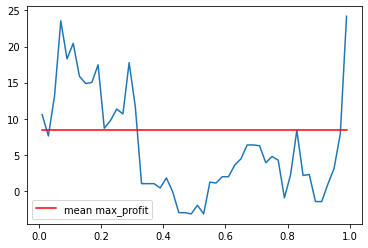

In [176]:
profits, ratios = get_pred_max_profit_for_quantiles(random_predictions)
mean_max_profit, mean_ratio = max_profit_metric(random_predictions.mean(1), targets)
print(mean_max_profit, mean_ratio)
plt.plot(quantiles_range, profits)
plt.plot(quantiles_range, np.ones_like(profits) * mean_max_profit, color='red', label='mean max_profit')
plt.legend()

# Implement threshold prediction based on distribution

In [137]:
# implemented above

# Convert max_profit metric to decision loss described in paper

In [ ]:
# TODO

# Cannot compare decision loss, under reliability gap (maybe usefull for mid-price prediction adjustment). Implement threshold calibration

In [177]:
# TODO implement threshold decision making